In [106]:
import numpy as np
from enum import IntEnum
import matplotlib.pyplot as plt
from itertools import product
from collections import namedtuple
from time import time

In [107]:
class Action(IntEnum):
    N = 0
    S = 1
    E = 2
    W = 3


class State(IntEnum):
    Terminal = -1


class Environment:
    def __init__(self, grid_size, reward_structure):
        self.grid_size = grid_size

        if reward_structure not in ['constant', 'dynamic']:
            raise ValueError("`reward_structure` must be one of ['constant', 'dynamic']")

        self.reward_structure = reward_structure

    def start(self):
        indices = np.random.choice(self.grid_size ** 2, size=2, replace=False)
        robot_pos, bomb_pos = map(tuple, np.unravel_index(indices, (self.grid_size, self.grid_size)))
        self.state = robot_pos, bomb_pos
        return self.state

    def move(self, action):
        reward = self.reward(action)
        robot_pos, bomb_pos = self.state
        next_robot_pos = tuple(np.clip(self.next_position(robot_pos, action), 0, self.grid_size - 1, dtype=int))

        # If the next robot position is the current bomb position, we've moved the bomb
        # If the bomb is outside the grid after moving, then the simulation is solved
        next_bomb_pos = bomb_pos
        if next_robot_pos == bomb_pos:
            next_bomb_pos = self.next_position(bomb_pos, action)
            x, y = next_bomb_pos
            if x < 0 or x >= self.grid_size or y < 0 or y >= self.grid_size:
                return (State.Terminal, State.Terminal), reward

        self.state = next_robot_pos, next_bomb_pos
        return self.state, reward

    def reward(self, action):
        # If we're using a constant reward structure
        if self.reward_structure == 'constant':
            return -1

        # If the next robot position isn't where the bomb is, we didn't move the bomb
        robot_pos, bomb_pos = self.state
        next_robot_pos = tuple(np.clip(self.next_position(robot_pos, action), 0, self.grid_size - 1, dtype=int))
        if next_robot_pos != bomb_pos:
            return -1

        # If the bomb was moved and the next bomb position is outside the grid, we won
        next_bomb_pos = self.next_position(bomb_pos, action)
        x, y = next_bomb_pos
        if x < 0 or x >= self.grid_size or y < 0 or y >= self.grid_size:
            return 10

        # If we moved the bomb further away from the center
        if self.dist(next_bomb_pos) > self.dist(bomb_pos):
            return 1

        # We moved the bomb closer to the center
        return -1

    def dist(self, pos):
        center = (self.grid_size / 2 - 0.5, self.grid_size / 2 - 0.5)
        return np.linalg.norm(np.subtract(center, pos))

    def next_position(self, pos, action):
        x, y = pos

        if action == Action.E:
            x += 1

        if action == Action.W:
            x -= 1

        if action == Action.S:
            y += 1

        if action == Action.N:
            y -= 1

        return x, y


class Learner:
    def __init__(self, alpha, eps, env, grid_size, max_iters):
        self.alpha = alpha
        self.eps = eps
        self.env = env
        self.grid_size = grid_size
        self.max_iters = max_iters

        # Create Q and policy for each state, action pair
        state_action_space = (grid_size, grid_size, grid_size, grid_size, len(Action))
        self.Q = np.zeros(state_action_space)
        self.policy = np.full(state_action_space, 1 / len(Action))

        # This is to speed up making the same probability arrays each iteration
        self.policy_lookup = np.full((len(Action), len(Action)), eps / len(Action))
        np.fill_diagonal(self.policy_lookup, 1 - eps + eps / len(Action))

    def episode(self):
        raise NotImplementedError()

    def learn(self):
        raise NotImplementedError()

    def run(self, nb_episodes):
        rewards, times = [], []
        for i in range(nb_episodes):
            start = time()
            rewards.append(self.learn())
            end = time()
            times.append(end - start)
        return rewards, times

    def final_policy(self):
        raise NotImplementedError()

    def plot(self, starting_state, title):
        self.env.state = starting_state
        robot_pos, bomb_pos = starting_state
        board = np.zeros((self.env.grid_size, self.env.grid_size))

        policy = self.final_policy()

        positions = []
        for i in range(20):
            probabilities = policy[tuple([*robot_pos, *bomb_pos])]
            action = Action(np.random.choice(np.arange(len(probabilities)), p=probabilities))

            (next_robot_pos, next_bomb_pos), reward = self.env.move(action)
            positions.append((robot_pos, bomb_pos, action))
            if next_robot_pos == State.Terminal:
                positions.append((next_robot_pos, next_bomb_pos, action))
                break
            robot_pos, bomb_pos = next_robot_pos, next_bomb_pos

        fig, axes = plt.subplots((len(positions) - 1) // 3 + 1, 3, figsize=(8, 3 * len(positions) // 3))
        for i in range(len(axes.ravel())):
            ax = axes[i // 3, i % 3]
            if i >= len(positions):
                ax.set_visible(False)
                continue
            robot_pos, bomb_pos, action = positions[i]
            current_board = np.copy(board)
            if robot_pos == State.Terminal:
                last_robot_pos, last_bomb_pos, action = positions[i - 1]
                robot_pos = self.env.next_position(last_robot_pos, action)
            else:
                current_board[bomb_pos] = 20

            current_board[robot_pos] = 10
            ax.imshow(current_board.T, vmin=0, vmax=20)
            ax.set_title(f"Time step {i+1}")
            ax.axes.xaxis.set_ticks([])
            ax.axes.yaxis.set_ticks([])
        plt.suptitle(title)
        plt.savefig(title.lower().replace(' ', '-'), dpi=300)
        plt.show()

    def q_values(self, starting_state):
        self.env.state = starting_state
        robot_pos, bomb_pos = starting_state
        policy = self.final_policy()
        for i in range(20):
            q = self.Q[tuple([*robot_pos, *bomb_pos])]
            print(f"Q((robotX: {robot_pos[0]}, robotY: {robot_pos[1]}), (bombX: {bomb_pos[0]}, bombY: {bomb_pos[1]})) = [N: {q[Action.N]:.2f}, E: {q[Action.E]:.2f}, S: {q[Action.S]:.2f}, W: {q[Action.W]:.2f}]")
            probabilities = policy[tuple([*robot_pos, *bomb_pos])]
            action = Action(np.random.choice(np.arange(len(probabilities)), p=probabilities))
            (next_robot_pos, next_bomb_pos), reward = self.env.move(action)
            if next_robot_pos == State.Terminal:
                break
            robot_pos, bomb_pos = next_robot_pos, next_bomb_pos


TimeStep = namedtuple('TimeStep', ['state', 'action', 'reward'])
class MCLearner(Learner):
    def __init__(self, env, grid_size, max_iters, eps, alpha):
        super().__init__(
            alpha=alpha,
            eps=eps,
            env=env,
            grid_size=grid_size,
            max_iters=max_iters
        )

    def learn(self):
        timesteps = []
        robot_pos, bomb_pos = self.env.start()

        # Generate Episode
        for i in range(self.max_iters):
            # Select which action to take based on pi
            probabilities = self.policy[tuple([*robot_pos, *bomb_pos])]
            action = Action(np.random.choice(np.arange(len(probabilities)), p=probabilities))

            # Move the robot
            (next_robot_pos, next_bomb_pos), reward = self.env.move(action)

            # Save the timestep for updating Q
            timesteps.append(
                TimeStep(state=(robot_pos, bomb_pos), action=action, reward=reward)
            )

            # If the next robot position is the terminal state, then we're done with the episode
            if next_robot_pos == State.Terminal:
                break

            # Update the robot and bomb position for the next step
            robot_pos, bomb_pos = next_robot_pos, next_bomb_pos

        # Keep a list of all state, action pairs we've seen
        seen = [(timestep.state, timestep.action) for timestep in timesteps]
        G = 0

        # Iterate over the timesteps backwards
        for t, timestep in zip(reversed(range(len(timesteps))), reversed(timesteps)):

            # Keep a sum of the total return from T-1 to t
            G = G + timestep.reward

            # If we've seen this state, action pair before then this isn't the first visit
            if (timestep.state, timestep.action) in seen[:t]:
                continue

            robot_pos, bomb_pos = timestep.state
            current_ind = tuple([*robot_pos, *bomb_pos, timestep.action])

            # Update Q
            self.Q[current_ind] = self.Q[current_ind] + self.alpha * (G - self.Q[current_ind])

            # Update the policy
            best_action = Action(np.argmax(self.Q[tuple([*robot_pos, *bomb_pos])]))
            self.policy[tuple([*robot_pos, *bomb_pos])] = self.policy_lookup[best_action]

        return G

    def final_policy(self):
        return self.policy


class QLearner(Learner):
    def __init__(self, env, grid_size, policy_type, alpha, max_iters, eps):
        super().__init__(
            alpha=alpha,
            eps=eps,
            env=env,
            grid_size=grid_size,
            max_iters=max_iters
        )

        if policy_type not in ['greedy', 'uniform']:
            raise ValueError("`policy_type` must be one of ['greedy', 'uniform']")

        self.policy_type = policy_type

    def learn(self):
        reward_sum = 0
        robot_pos, bomb_pos = self.env.start()
        for i in range(self.max_iters):
            # Select which action to take based on pi
            probabilities = self.policy[tuple([*robot_pos, *bomb_pos])]
            action = Action(
                np.random.choice(np.arange(len(probabilities)), p=probabilities)
            )

            # Move the robot
            (next_robot_pos, next_bomb_pos), reward = self.env.move(action)

            # Add the reward for that step to our total reward
            reward_sum += reward

            # Update Q based on the current state, action and the next state, action
            current_ind = tuple([*robot_pos, *bomb_pos, action])

            if next_robot_pos == State.Terminal:
                next_Q = 0
            else:
                next_ind = tuple([*next_robot_pos, *next_bomb_pos])
                next_Q = np.max(self.Q[next_ind])
            self.Q[current_ind] = self.Q[current_ind] + self.alpha * (reward + next_Q - self.Q[current_ind])

            # If we're using a greedy policy (over uniform), update our policy
            if self.policy_type == 'greedy':
                best_action = Action(
                    np.argmax(self.Q[tuple([*robot_pos, *bomb_pos])])
                )
                self.policy[tuple([*robot_pos, *bomb_pos])] = self.policy_lookup[best_action]

            # If the next robot position is the terminal state, then we're done with the episode
            if next_robot_pos == State.Terminal:
                break

            # Update the robot and bomb position for the next step
            robot_pos, bomb_pos = next_robot_pos, next_bomb_pos

        return reward_sum

    def final_policy(self):
        policy = np.zeros_like(self.policy)
        for a, b, c, d in product(range(self.env.grid_size), repeat=4):
            policy[(a, b, c, d, np.argmax(self.Q[(a, b, c, d)]))] = 1

        return policy

In [89]:
envs = [
    Environment(grid_size, 'constant'),
    Environment(grid_size, 'dynamic')
]


move_sets = [
    [
        Action.E,
        Action.E,
        Action.N,
        Action.W,
        Action.W
    ],
    [
        Action.E,
        Action.N,
        Action.N,
        Action.N,
        Action.N,
        Action.N
    ]
]
starting_state = (0, 5), (1, 4)
for env in envs:
    for move_set in move_sets:
        env.state = starting_state
        robot_pos, bomb_pos = starting_state
        total_reward = 0
        for move in move_set:
            (robot_pos, bomb_pos), reward = env.move(move)
            total_reward += reward
            if robot_pos == State.Terminal:
                break
        print(total_reward, env.reward_structure, move_set)

-5 constant [<Action.E: 2>, <Action.E: 2>, <Action.N: 0>, <Action.W: 3>, <Action.W: 3>]
-6 constant [<Action.E: 2>, <Action.N: 0>, <Action.N: 0>, <Action.N: 0>, <Action.N: 0>, <Action.N: 0>]
8 dynamic [<Action.E: 2>, <Action.E: 2>, <Action.N: 0>, <Action.W: 3>, <Action.W: 3>]
11 dynamic [<Action.E: 2>, <Action.N: 0>, <Action.N: 0>, <Action.N: 0>, <Action.N: 0>, <Action.N: 0>]


In [135]:
n = 50000
alpha = 0.1
eps = 0.1
grid_size = 8
max_iters = 1000

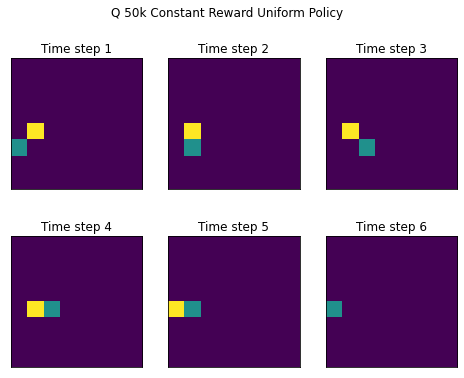

Q((robotX: 0, robotY: 5), (bombX: 1, bombY: 4)) = [N: -7.00, E: -5.00, S: -7.00, W: -6.00]
Q((robotX: 1, robotY: 5), (bombX: 1, bombY: 4)) = [N: -5.00, E: -4.00, S: -6.00, W: -6.00]
Q((robotX: 2, robotY: 5), (bombX: 1, bombY: 4)) = [N: -3.00, E: -5.00, S: -5.00, W: -5.00]
Q((robotX: 2, robotY: 4), (bombX: 1, bombY: 4)) = [N: -4.00, E: -4.00, S: -4.00, W: -2.00]
Q((robotX: 1, robotY: 4), (bombX: 0, bombY: 4)) = [N: -3.00, E: -3.00, S: -3.00, W: -1.00]


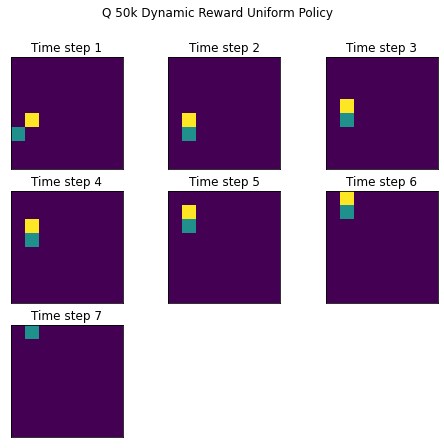

Q((robotX: 0, robotY: 5), (bombX: 1, bombY: 4)) = [N: 10.00, E: 11.00, S: 9.00, W: 10.00]
Q((robotX: 1, robotY: 5), (bombX: 1, bombY: 4)) = [N: 12.00, E: 10.00, S: 10.00, W: 10.00]
Q((robotX: 1, robotY: 4), (bombX: 1, bombY: 3)) = [N: 13.00, E: 11.00, S: 11.00, W: 11.00]
Q((robotX: 1, robotY: 3), (bombX: 1, bombY: 2)) = [N: 12.00, E: 10.00, S: 10.00, W: 10.00]
Q((robotX: 1, robotY: 2), (bombX: 1, bombY: 1)) = [N: 11.00, E: 9.00, S: 9.00, W: 9.00]
Q((robotX: 1, robotY: 1), (bombX: 1, bombY: 0)) = [N: 10.00, E: 9.00, S: 8.00, W: 8.00]


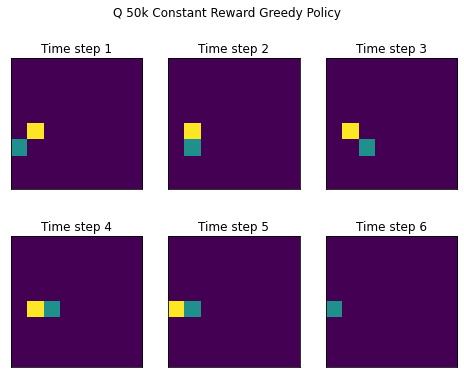

Q((robotX: 0, robotY: 5), (bombX: 1, bombY: 4)) = [N: -4.90, E: -4.81, S: -4.94, W: -4.85]
Q((robotX: 1, robotY: 5), (bombX: 1, bombY: 4)) = [N: -4.08, E: -4.00, S: -4.28, W: -4.18]
Q((robotX: 2, robotY: 5), (bombX: 1, bombY: 4)) = [N: -3.00, E: -4.01, S: -4.54, W: -3.43]
Q((robotX: 2, robotY: 4), (bombX: 1, bombY: 4)) = [N: -3.99, E: -3.96, S: -3.98, W: -2.00]
Q((robotX: 1, robotY: 4), (bombX: 0, bombY: 4)) = [N: -3.00, E: -3.00, S: -3.00, W: -1.00]


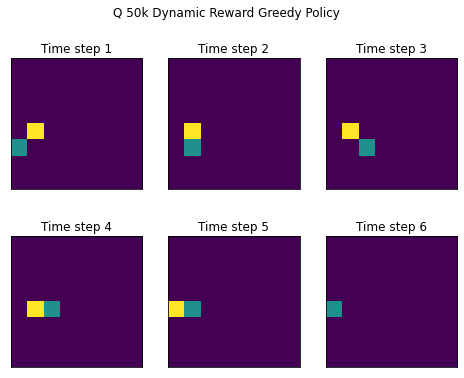

Q((robotX: 0, robotY: 5), (bombX: 1, bombY: 4)) = [N: 0.12, E: 4.71, S: -0.20, W: 0.40]
Q((robotX: 1, robotY: 5), (bombX: 1, bombY: 4)) = [N: 4.66, E: 9.00, S: -0.09, W: 0.16]
Q((robotX: 2, robotY: 5), (bombX: 1, bombY: 4)) = [N: 10.00, E: 4.23, S: 4.03, W: 3.22]
Q((robotX: 2, robotY: 4), (bombX: 1, bombY: 4)) = [N: 8.94, E: 8.84, S: 8.95, W: 11.00]
Q((robotX: 1, robotY: 4), (bombX: 0, bombY: 4)) = [N: 7.99, E: 7.94, S: 7.95, W: 10.00]


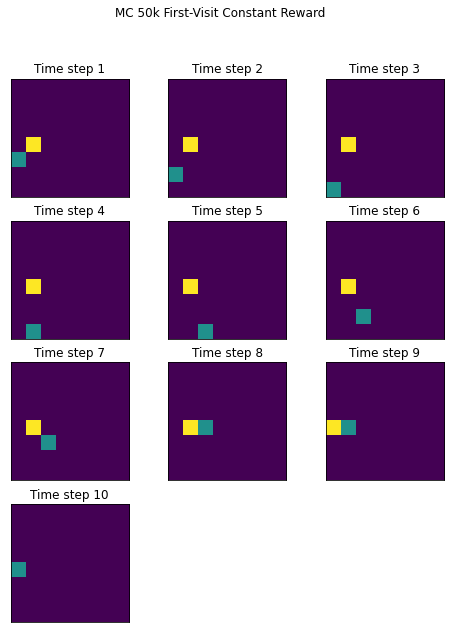

Q((robotX: 0, robotY: 5), (bombX: 1, bombY: 4)) = [N: -198.30, E: -203.12, S: -12.68, W: -183.27]
Q((robotX: 0, robotY: 6), (bombX: 1, bombY: 4)) = [N: -95.39, E: -73.63, S: -10.66, W: -58.54]
Q((robotX: 0, robotY: 7), (bombX: 1, bombY: 4)) = [N: -163.37, E: -8.65, S: -136.27, W: -126.16]
Q((robotX: 1, robotY: 7), (bombX: 1, bombY: 4)) = [N: -257.84, E: -6.83, S: -165.50, W: -118.29]
Q((robotX: 2, robotY: 7), (bombX: 1, bombY: 4)) = [N: -5.59, E: -150.20, S: -210.05, W: -212.83]
Q((robotX: 2, robotY: 6), (bombX: 1, bombY: 4)) = [N: -5.01, E: -119.67, S: -182.41, W: -142.35]
Q((robotX: 2, robotY: 5), (bombX: 1, bombY: 4)) = [N: -3.35, E: -102.30, S: -64.37, W: -88.88]
Q((robotX: 2, robotY: 4), (bombX: 1, bombY: 4)) = [N: -33.09, E: -54.13, S: -39.45, W: -2.06]
Q((robotX: 1, robotY: 4), (bombX: 0, bombY: 4)) = [N: -4.34, E: -3.61, S: -6.67, W: -1.00]


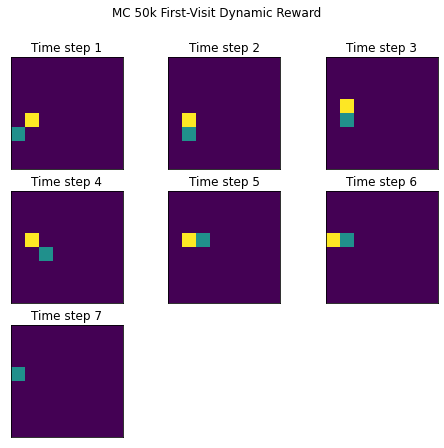

Q((robotX: 0, robotY: 5), (bombX: 1, bombY: 4)) = [N: -127.28, E: 6.10, S: -78.30, W: -81.98]
Q((robotX: 1, robotY: 5), (bombX: 1, bombY: 4)) = [N: 6.82, E: -18.75, S: -29.49, W: -32.04]
Q((robotX: 1, robotY: 4), (bombX: 1, bombY: 3)) = [N: 2.53, E: 7.84, S: 0.09, W: 4.75]
Q((robotX: 2, robotY: 4), (bombX: 1, bombY: 3)) = [N: 9.31, E: 1.47, S: 4.97, W: 7.26]
Q((robotX: 2, robotY: 3), (bombX: 1, bombY: 3)) = [N: 5.91, E: 6.12, S: 7.30, W: 10.61]
Q((robotX: 1, robotY: 3), (bombX: 0, bombY: 3)) = [N: 7.88, E: 7.54, S: 7.51, W: 10.00]
Q((robotX: 2, robotY: 3), (bombX: 0, bombY: 3)) = [N: -34.73, E: -33.75, S: -93.51, W: 8.79]
Q((robotX: 1, robotY: 3), (bombX: 0, bombY: 3)) = [N: 7.88, E: 7.54, S: 7.51, W: 10.00]


In [83]:
learners = [
    QLearner(env_q_constant_uniform, grid_size, 'uniform', alpha, max_iters, eps),
    QLearner(env_q_dynamic_uniform, grid_size, 'uniform', alpha, max_iters, eps),
    QLearner(env_q_constant_greedy, grid_size, 'greedy', alpha, max_iters, eps),
    QLearner(env_q_dynamic_greedy, grid_size, 'greedy', alpha, max_iters, eps),
    MCLearner(env_mc_constant, grid_size, max_iters, eps, alpha),
    MCLearner(env_mc_dynamic, grid_size, max_iters, eps, alpha)
]
trained_learners = [
    learner_q_constant_uniform,
    learner_q_dynamic_uniform,
    learner_q_constant_greedy,
    learner_q_dynamic_greedy,
    learner_mc_constant,
    learner_mc_dynamic
]
titles = [
    'Q 50k Constant Reward Uniform Policy',
    'Q 50k Dynamic Reward Uniform Policy',
    'Q 50k Constant Reward Greedy Policy',
    'Q 50k Dynamic Reward Greedy Policy',
    'MC 50k First-Visit Constant Reward',
    'MC 50k First-Visit Dynamic Reward'
]

starting_state = (0, 5), (1, 4)
for l, tl, t in zip(learners, trained_learners, titles):
    l.Q = tl.Q
    l.policy = tl.policy
    l.plot(starting_state, t)
    l.q_values(starting_state)

## Q Learning, 50k Episodes, Constant Reward, Uniform Policy

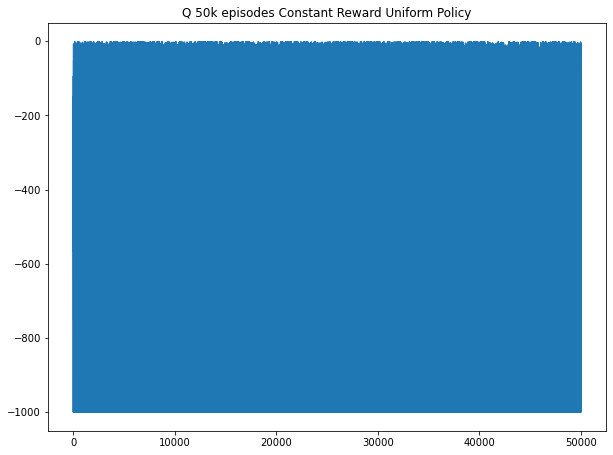

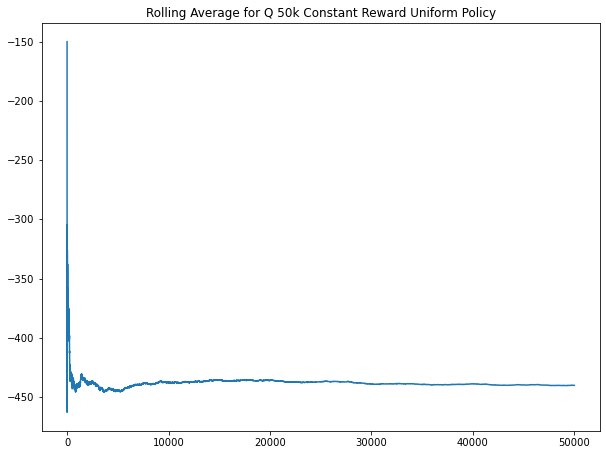

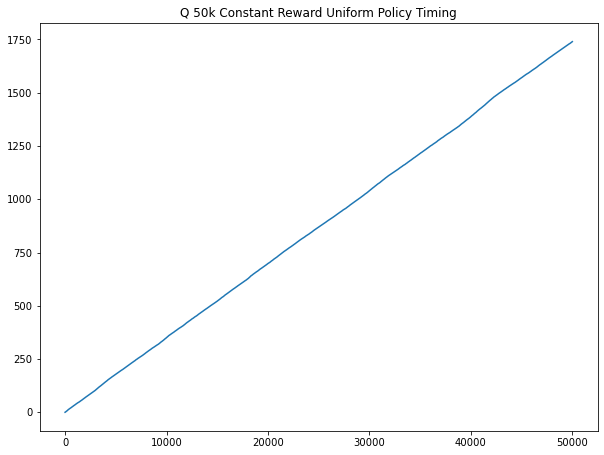

[-440.06254875682595, -440.05580669680364, -440.06006600660066, -440.06256500520044, -440.07376442586553, -440.07428297131884, -440.06738134762696, -440.07232]


In [136]:
env_q_constant_uniform = Environment(grid_size, 'constant')
learner_q_constant_uniform = QLearner(env_q_constant_uniform, grid_size, 'uniform', alpha, max_iters, eps)
rewards_q_constant_uniform, time_q_constant_uniform = learner_q_constant_uniform.run(n)

plt.figure(figsize=(10, 7.5))
plt.plot(range(len(rewards_q_constant_uniform)), rewards_q_constant_uniform)
plt.title('Q 50k episodes Constant Reward Uniform Policy')
plt.show()

avg_q_constant_uniform = [r / (i + 1) for i, r in enumerate(np.cumsum(rewards_q_constant_uniform))]
plt.figure(figsize=(10, 7.5))
plt.plot(range(len(avg_q_constant_uniform)), avg_q_constant_uniform)
plt.title('Rolling Average for Q 50k Constant Reward Uniform Policy')
plt.show()

plt.figure(figsize=(10, 7.5))
plt.plot(range(len(time_q_constant_uniform)), np.cumsum(time_q_constant_uniform))
plt.title('Q 50k Constant Reward Uniform Policy Timing')
plt.show()

print(avg_q_constant_uniform[-8:])

## Q Learning, 50k Episodes, Dynamic Reward, Uniform Policy

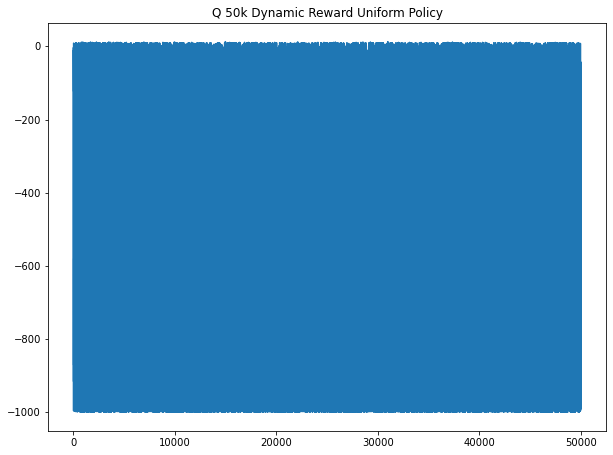

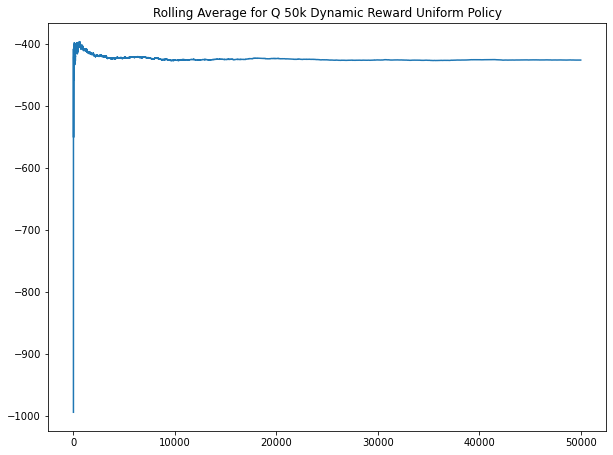

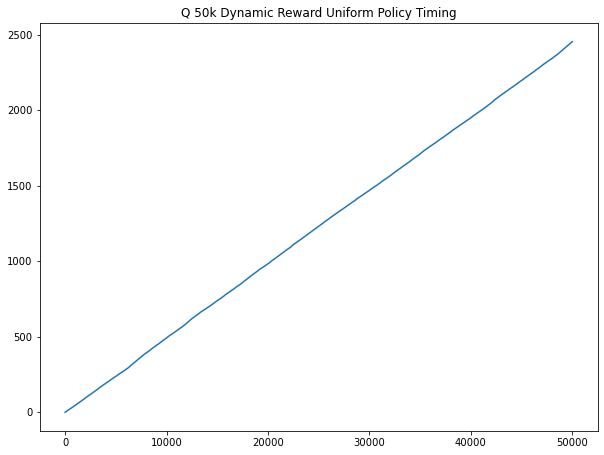

[-426.00790110615486, -426.0192223066768, -426.0157415741574, -426.01038083046643, -426.00596035762146, -425.9988399535981, -425.9911798235965, -425.99138]


In [137]:
env_q_dynamic_uniform = Environment(grid_size, 'dynamic')
learner_q_dynamic_uniform = QLearner(env_q_dynamic_uniform, grid_size, 'uniform', alpha, max_iters, eps)
rewards_q_dynamic_uniform, time_q_dynamic_uniform = learner_q_dynamic_uniform.run(n)

plt.figure(figsize=(10, 7.5))
plt.plot(range(len(rewards_q_dynamic_uniform)), rewards_q_dynamic_uniform)
plt.title('Q 50k Dynamic Reward Uniform Policy')
plt.show()

avg_q_dynamic_uniform = [r / (i + 1) for i, r in enumerate(np.cumsum(rewards_q_dynamic_uniform))]
plt.figure(figsize=(10, 7.5))
plt.plot(range(len(avg_q_dynamic_uniform)), avg_q_dynamic_uniform)
plt.title('Rolling Average for Q 50k Dynamic Reward Uniform Policy')
plt.show()

plt.figure(figsize=(10, 7.5))
plt.plot(range(len(time_q_dynamic_uniform)), np.cumsum(time_q_dynamic_uniform))
plt.title('Q 50k Dynamic Reward Uniform Policy Timing')
plt.show()

print(avg_q_dynamic_uniform[-8:])

## Q Learning, 50k Episodes, Constant Reward, Greedy Policy

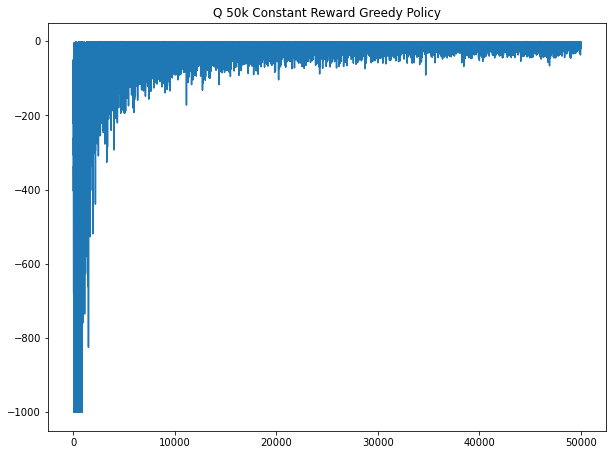

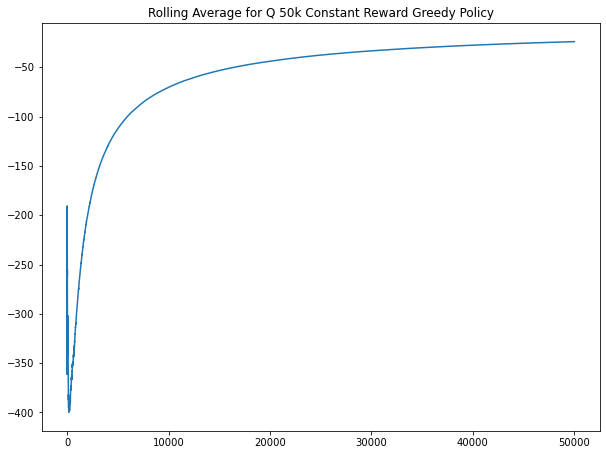

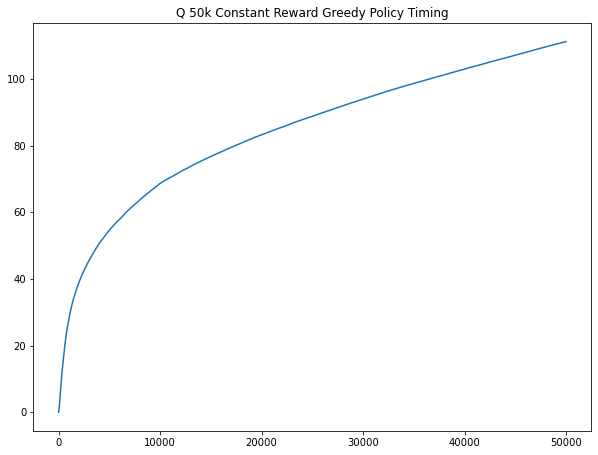

[-23.886864160982537, -23.886766411969436, -23.886508650865085, -23.88619089527162, -23.885813148788927, -23.885715428617143, -23.885357707154142, -23.88492]


In [138]:
env_q_constant_greedy = Environment(grid_size, 'constant')
learner_q_constant_greedy = QLearner(env_q_constant_greedy, grid_size, 'greedy', alpha, max_iters, eps)
rewards_q_constant_greedy, time_q_constant_greedy = learner_q_constant_greedy.run(n)

plt.figure(figsize=(10, 7.5))
plt.plot(range(len(rewards_q_constant_greedy)), rewards_q_constant_greedy)
plt.title('Q 50k Constant Reward Greedy Policy')
plt.show()

avg_q_constant_greedy = [r / (i + 1) for i, r in enumerate(np.cumsum(rewards_q_constant_greedy))]
plt.figure(figsize=(10, 7.5))
plt.plot(range(len(avg_q_constant_greedy)), avg_q_constant_greedy)
plt.title('Rolling Average for Q 50k Constant Reward Greedy Policy')
plt.show()

plt.figure(figsize=(10, 7.5))
plt.plot(range(len(time_q_constant_greedy)), np.cumsum(time_q_constant_greedy))
plt.title('Q 50k Constant Reward Greedy Policy Timing')
plt.show()

print(avg_q_constant_greedy[-8:])

## Q Learning, 50k Episodes, Dynamic Reward, Greedy Policy

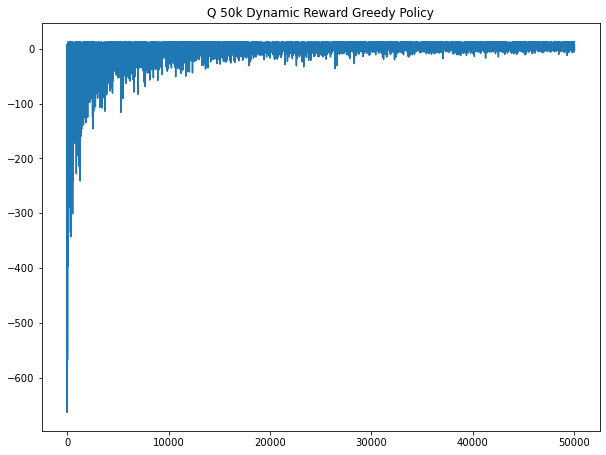

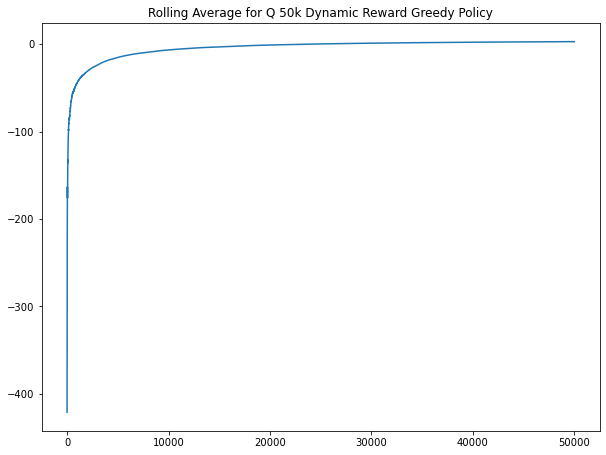

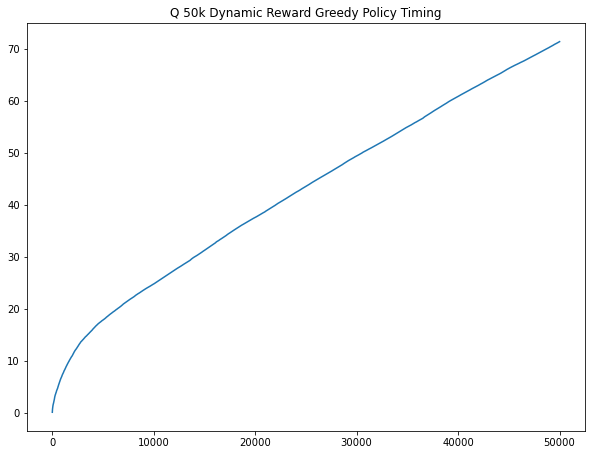

[2.9961794651251177, 2.996359563147578, 2.9963596359635964, 2.996359708776702, 2.9965197911874712, 2.9964998599943997, 2.996539930798616, 2.99642]


In [139]:
env_q_dynamic_greedy = Environment(grid_size, 'dynamic')
learner_q_dynamic_greedy = QLearner(env_q_dynamic_greedy, grid_size, 'greedy', alpha, max_iters, eps)
rewards_q_dynamic_greedy, time_q_dynamic_greedy = learner_q_dynamic_greedy.run(n)

plt.figure(figsize=(10, 7.5))
plt.plot(range(len(rewards_q_dynamic_greedy)), rewards_q_dynamic_greedy)
plt.title('Q 50k Dynamic Reward Greedy Policy')
plt.show()

avg_q_dynamic_greedy = [r / (i + 1) for i, r in enumerate(np.cumsum(rewards_q_dynamic_greedy))]
plt.figure(figsize=(10, 7.5))
plt.plot(range(len(avg_q_dynamic_greedy)), avg_q_dynamic_greedy)
plt.title('Rolling Average for Q 50k Dynamic Reward Greedy Policy')
plt.show()

plt.figure(figsize=(10, 7.5))
plt.plot(range(len(time_q_dynamic_greedy)), np.cumsum(time_q_dynamic_greedy))
plt.title('Q 50k Dynamic Reward Greedy Policy Timing')
plt.show()

print(avg_q_dynamic_greedy[-8:])

## MC Learning, 50k Episodes, Constant Reward

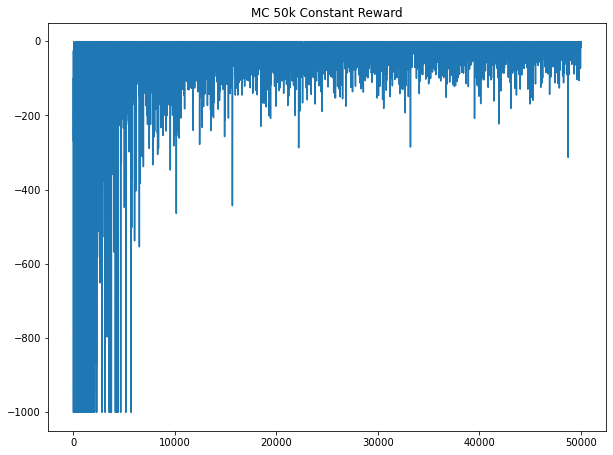

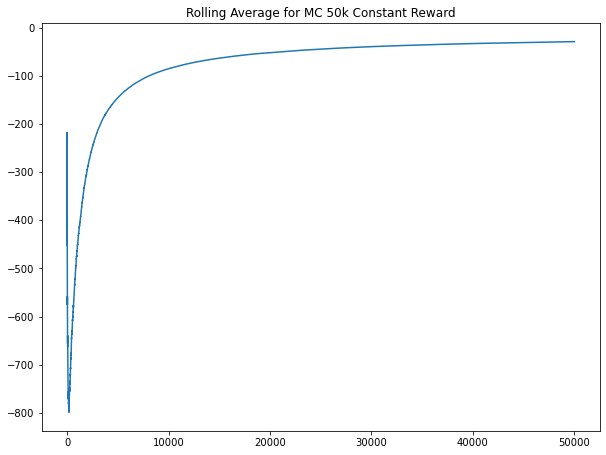

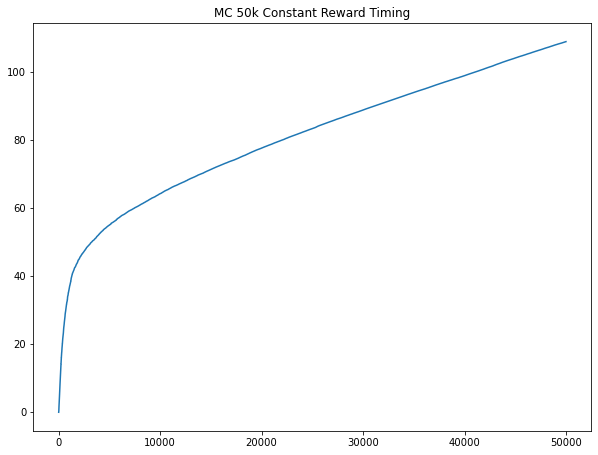

[-29.20314844078171, -29.202584310117214, -29.202160216021603, -29.201696135690856, -29.201352081124867, -29.201048041921677, -29.200664013280267, -29.2004]


In [140]:
env_mc_constant = Environment(grid_size, 'constant')
learner_mc_constant = MCLearner(env_mc_constant, grid_size, max_iters, eps, alpha)
rewards_mc_constant, time_mc_constant = learner_mc_constant.run(n)
plt.figure(figsize=(10, 7.5))
plt.plot(range(len(rewards_mc_constant)), rewards_mc_constant)
plt.title('MC 50k Constant Reward')
plt.show()

avg_mc_constant = [r / (i + 1) for i, r in enumerate(np.cumsum(rewards_mc_constant))]
plt.figure(figsize=(10, 7.5))
plt.plot(range(len(avg_mc_constant)), avg_mc_constant)
plt.title('Rolling Average for MC 50k Constant Reward')
plt.show()

plt.figure(figsize=(10, 7.5))
plt.plot(range(len(time_mc_constant)), np.cumsum(time_mc_constant))
plt.title('MC 50k Constant Reward Timing')
plt.show()

print(avg_mc_constant[-8:])

## MC Learning, 50k Episodes, Dynamic Reward

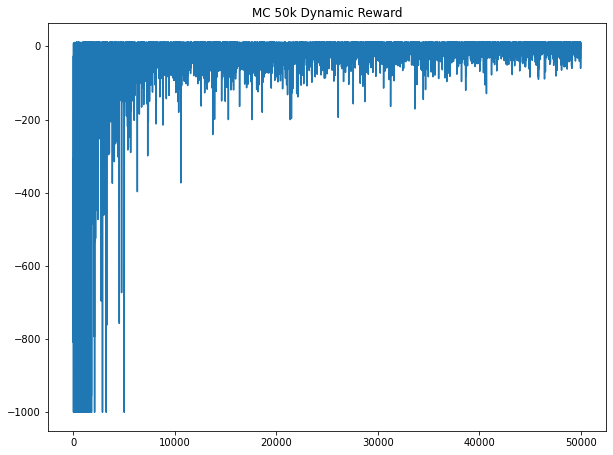

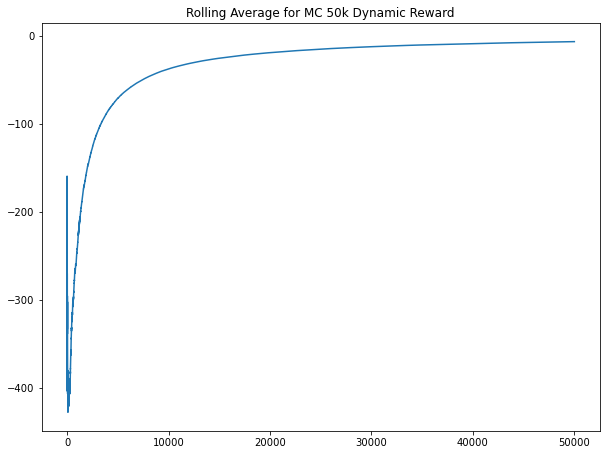

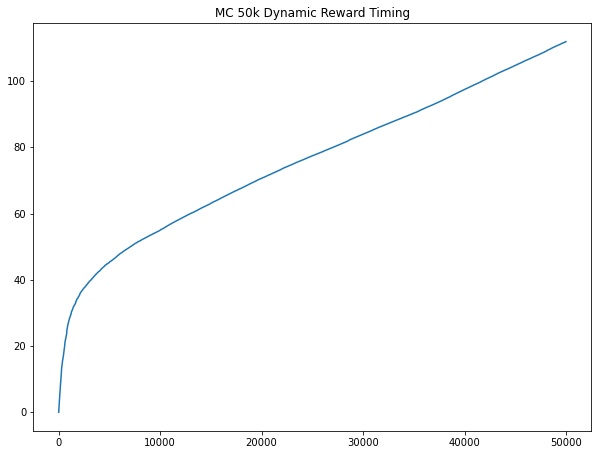

[-6.507231012341728, -6.506900828099372, -6.506590659065907, -6.506420513641091, -6.5064503870232215, -6.506220248809952, -6.50595011900238, -6.50592]


In [141]:
env_mc_dynamic = Environment(grid_size, 'dynamic')
learner_mc_dynamic = MCLearner(env_mc_dynamic, grid_size, max_iters, eps, alpha)
rewards_mc_dynamic, time_mc_dynamic = learner_mc_dynamic.run(n)
plt.figure(figsize=(10, 7.5))
plt.plot(range(len(rewards_mc_dynamic)), rewards_mc_dynamic)
plt.title('MC 50k Dynamic Reward')
plt.show()

avg_mc_dynamic = [r / (i + 1) for i, r in enumerate(np.cumsum(rewards_mc_dynamic))]
plt.figure(figsize=(10, 7.5))
plt.plot(range(len(avg_mc_dynamic)), avg_mc_dynamic)
plt.title('Rolling Average for MC 50k Dynamic Reward')
plt.show()

plt.figure(figsize=(10, 7.5))
plt.plot(range(len(time_mc_dynamic)), np.cumsum(time_mc_dynamic))
plt.title('MC 50k Dynamic Reward Timing')
plt.show()

print(avg_mc_dynamic[-8:])

# Constant Reward vs Time

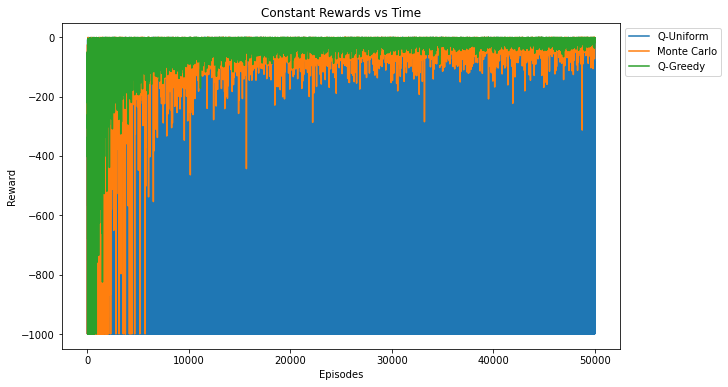

In [154]:
plt.figure(figsize=(10, 6))
plt.title("Constant Rewards vs Time")
plt.plot(range(len(rewards_q_constant_uniform)), rewards_q_constant_uniform, label="Q-Uniform")
plt.plot(range(len(rewards_mc_constant)), rewards_mc_constant, label="Monte Carlo")
plt.plot(range(len(rewards_q_constant_greedy)), rewards_q_constant_greedy, label="Q-Greedy")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("constant-rewards-vs-time.png", bbox_inches='tight')
plt.show()

# Dynamic Reward vs Time

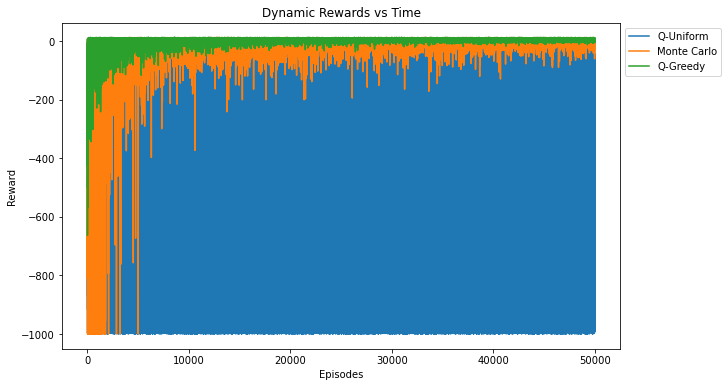

In [155]:
plt.figure(figsize=(10, 6))
plt.title("Dynamic Rewards vs Time")
plt.plot(range(len(rewards_q_dynamic_uniform)), rewards_q_dynamic_uniform, label="Q-Uniform")
plt.plot(range(len(rewards_mc_dynamic)), rewards_mc_dynamic, label="Monte Carlo")
plt.plot(range(len(rewards_q_dynamic_greedy)), rewards_q_dynamic_greedy, label="Q-Greedy")
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.savefig("dynamic-rewards-vs-time.png", bbox_inches='tight')
plt.show()

# Average Constant Reward vs Time

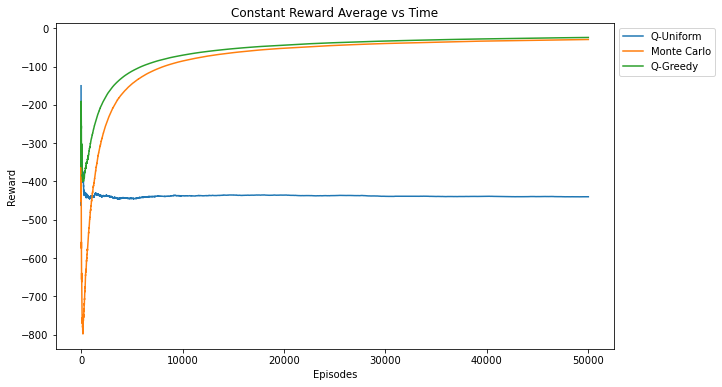

In [156]:
plt.figure(figsize=(10, 6))
plt.title("Constant Reward Average vs Time")
plt.plot(range(len(avg_q_constant_uniform)), avg_q_constant_uniform, label="Q-Uniform")
plt.plot(range(len(avg_mc_constant)), avg_mc_constant, label="Monte Carlo")
plt.plot(range(len(avg_q_constant_greedy)), avg_q_constant_greedy, label="Q-Greedy")
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.savefig("constant-reward-average-vs-time.png", bbox_inches='tight')
plt.show()

# Average Dynamic Reward vs Time

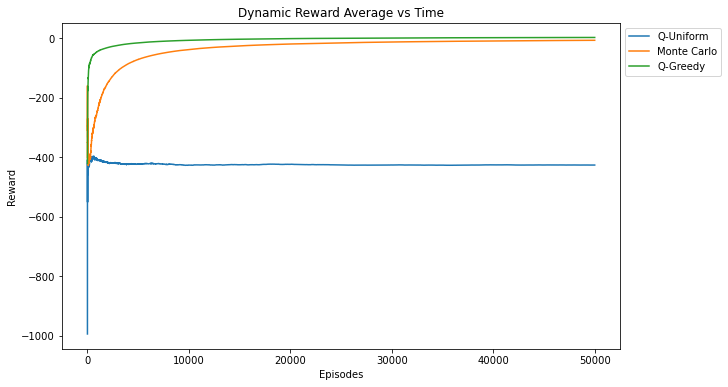

In [157]:
plt.figure(figsize=(10, 6))
plt.title("Dynamic Reward Average vs Time")
plt.plot(range(len(avg_q_dynamic_uniform)), avg_q_dynamic_uniform, label="Q-Uniform")
plt.plot(range(len(avg_mc_dynamic)), avg_mc_dynamic, label="Monte Carlo")
plt.plot(range(len(avg_q_dynamic_greedy)), avg_q_dynamic_greedy, label="Q-Greedy")
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.savefig("dynamic-reward-average-vs-time.png", bbox_inches='tight')
plt.show()

# Constant Reward Average Timing

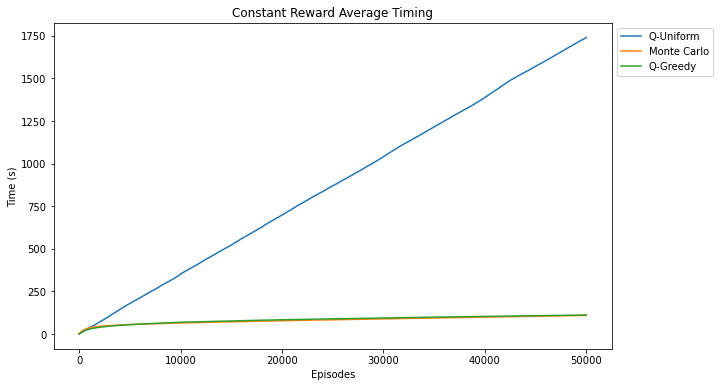

In [158]:
plt.figure(figsize=(10, 6))
plt.title("Constant Reward Average Timing")
plt.plot(range(len(time_q_constant_uniform)), np.cumsum(time_q_constant_uniform), label="Q-Uniform")
plt.plot(range(len(time_mc_constant)), np.cumsum(time_mc_constant), label="Monte Carlo")
plt.plot(range(len(time_q_constant_greedy)), np.cumsum(time_q_constant_greedy), label="Q-Greedy")
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Episodes")
plt.ylabel("Time (s)")
plt.savefig("constant-reward-timing.png", bbox_inches='tight')
plt.show()

# Dynamic Reward Average Timing

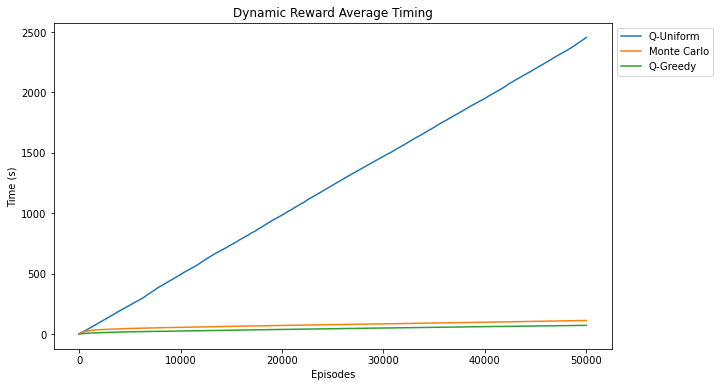

In [159]:
plt.figure(figsize=(10, 6))
plt.title("Dynamic Reward Average Timing")
plt.plot(range(len(time_q_dynamic_uniform)), np.cumsum(time_q_dynamic_uniform), label="Q-Uniform")
plt.plot(range(len(time_mc_dynamic)), np.cumsum(time_mc_dynamic), label="Monte Carlo")
plt.plot(range(len(time_q_dynamic_greedy)), np.cumsum(time_q_dynamic_greedy), label="Q-Greedy")
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Episodes")
plt.ylabel("Time (s)")
plt.savefig("dynamic-reward-timing.png", bbox_inches='tight')
plt.show()